![picture](https://drive.google.com/uc?export=view&id=1aCi0iqjl3-a7IsshXoF9Kp8Ufp9D8Diq)


![picture](https://drive.google.com/uc?export=view&id=1eDuB627YP3Yjvv64ScYElU37R2mMWWMZ)

![picture](https://drive.google.com/uc?export=view&id=1_FqRFnbuNfhaAubYNvyiD4KzglBQZuyB)

## Import

In [ ]:
pip install lightkurve

In [ ]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import lightkurve as lk
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import os
import concurrent.futures

## Mozgóátlag

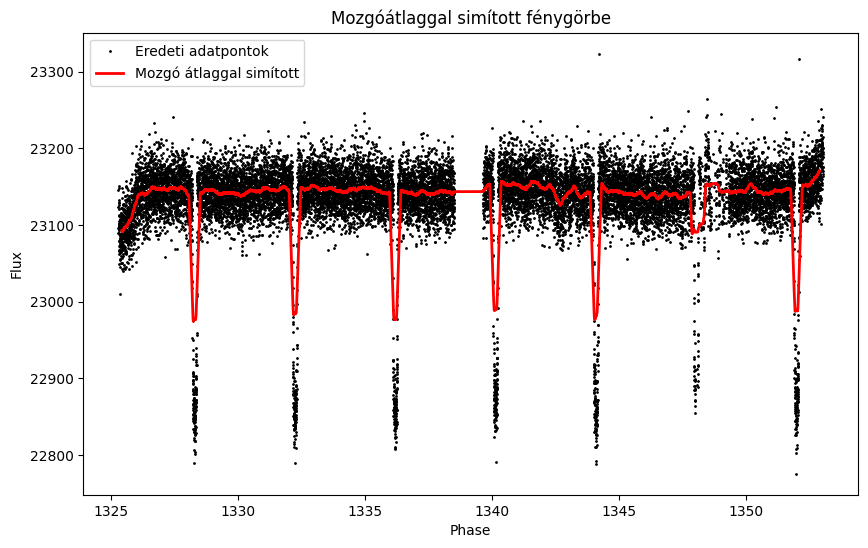

In [ ]:
TIC = "TIC 92352620"
sector_data = lk.search_lightcurve(TIC, author="SPOC", sector=1)
lc = sector_data.download()

# Fold
period = 3.950054

# Mozgóátlag
def moving_average(x, y, window_size=10):
    assert len(x) == len(y)
    cumsum_vec = np.cumsum(np.insert(y, 0, 0))
    ma = (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size
    return x[int(window_size/2):-int(window_size/2)+1], ma

# Mozgóátlag
window_size = 200
ma_time, ma_flux = moving_average(lc.time.value, lc.flux.value, window_size=window_size)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(lc.time.value, lc.flux.value, 'k.', markersize=2, label='Eredeti adatpontok')
plt.plot(ma_time, ma_flux, 'r-', linewidth=2, label='Mozgó átlaggal simított')
plt.legend()
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.title('Mozgóátlaggal simított fénygörbe')
plt.show()


## Hajtogatott fénygörbe (fold)

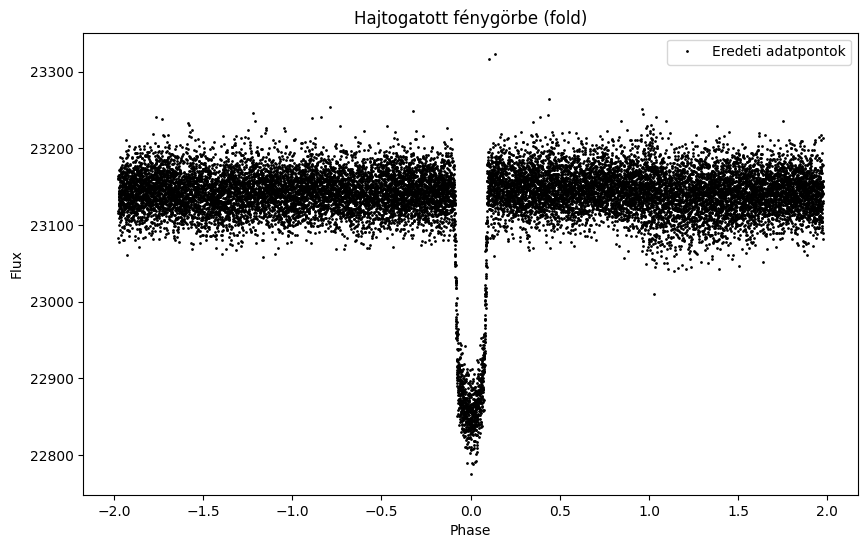

In [ ]:
TIC = "TIC 92352620"
sector_data = lk.search_lightcurve(TIC, author="SPOC", sector=1)
lc = sector_data.download()

# Fold
period = 3.950054
epoch = 1328.29934
folded_lc = lc.fold(period, epoch)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(folded_lc.time.value, folded_lc.flux.value, 'k.', markersize=2, label='Eredeti adatpontok')
plt.legend()
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.title('Hajtogatott fénygörbe (fold)')
plt.show()

## Automatizált vektorgenerálás - Savitzky-Golay Filterrel

/usr/local/lib/python3.10/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


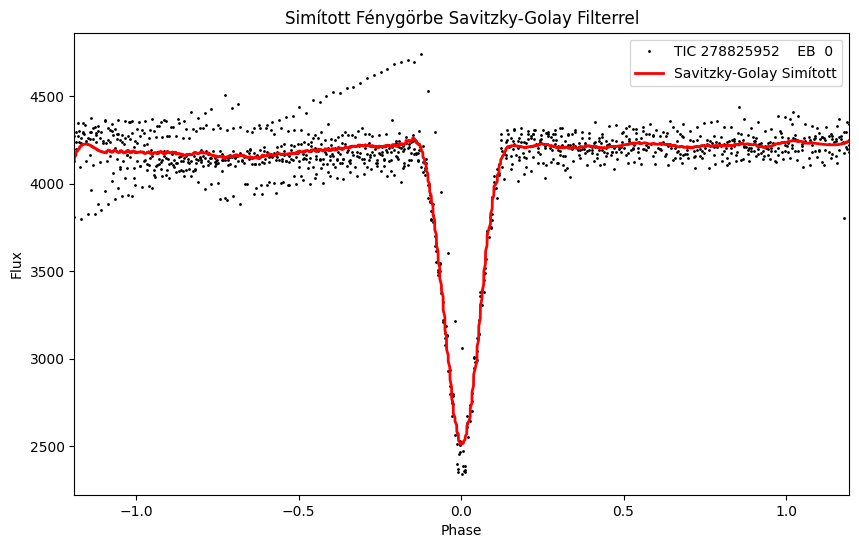

/usr/local/lib/python3.10/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 7 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


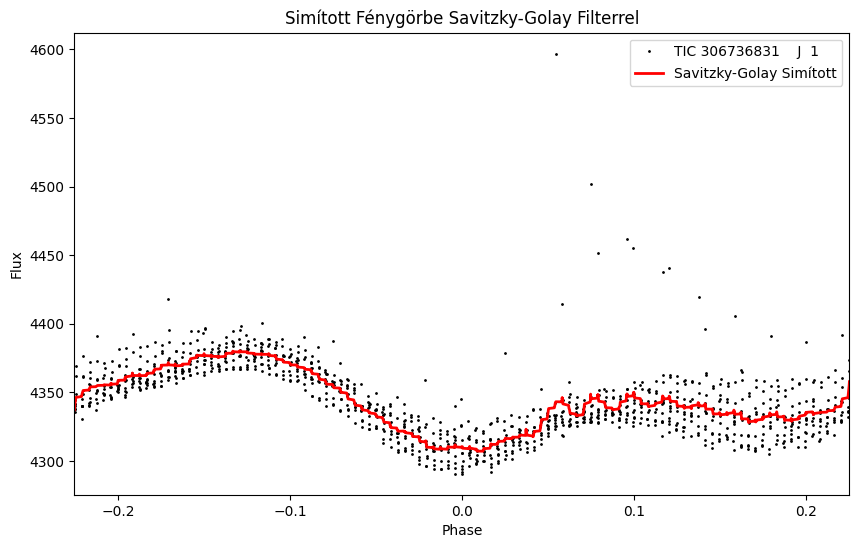

/usr/local/lib/python3.10/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


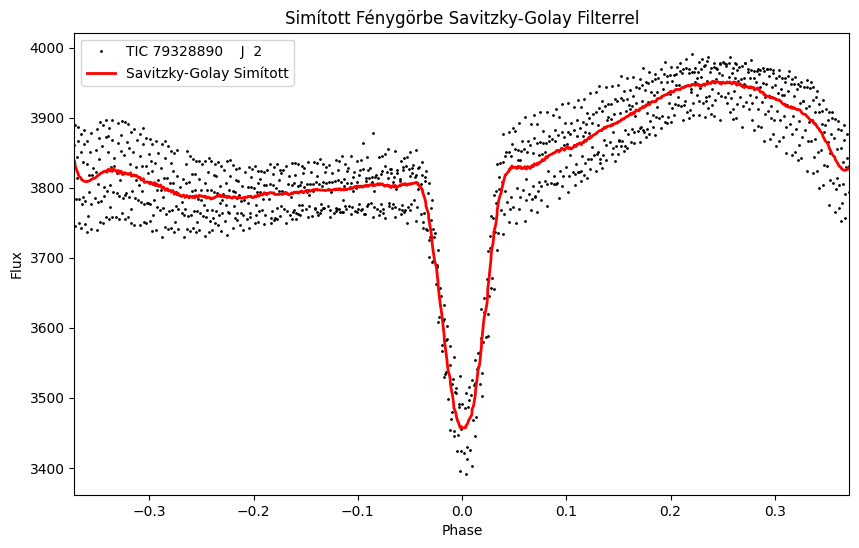

/usr/local/lib/python3.10/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


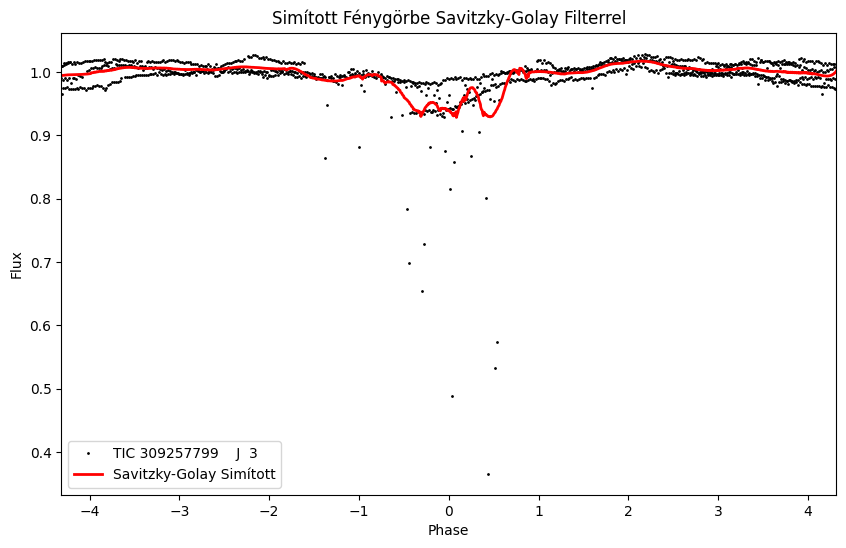

/usr/local/lib/python3.10/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 8 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


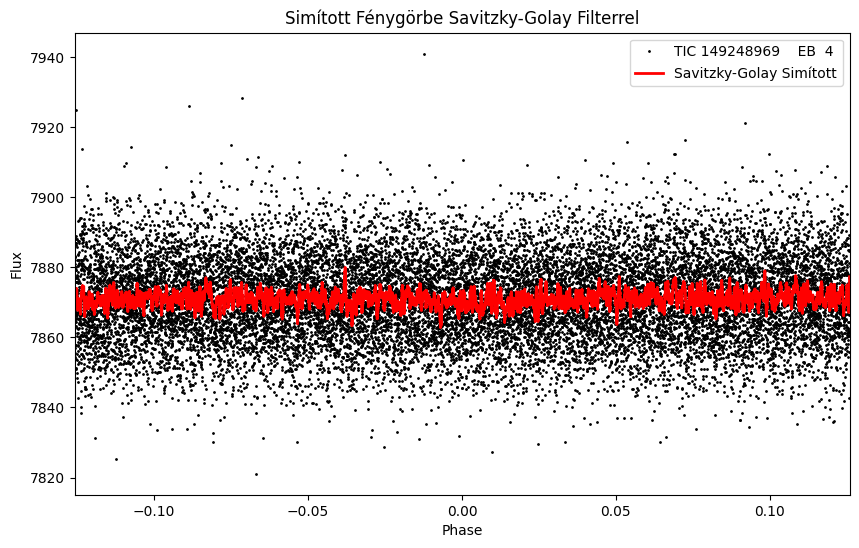

In [ ]:
lightcurve_df = pd.DataFrame(columns=['normalized_flux', 'tic_id'])
df = pd.read_csv("tces.csv")

for ind in df[0:5].index:
  sector_data = lk.search_lightcurve(f'TIC {df["tic_id"][ind]}', sector = df["Sectors"][ind])
  try:
    lc = sector_data.download()
  except:
    continue

  if lc is not None:
    try:
      if df["Period"][ind] is not None:
        folded_lc = lc.fold(df["Period"][ind], df["Epoc"][ind])
        #lc.plot()
    except:
      continue

    # NaN-ok elvátvolítása
    folded_lc = folded_lc.remove_nans()

    window_length = 101 # Az ablakméretnek kisebbnek kell lennie a rendelkezésre álló pontoknál, és páratlan kell, hogy legyen
    polyorder = 4 # Hanyadfokú polinomot illesszünk

    # Savitzky-Golay filter
    try:
      smoothed_flux = savgol_filter(folded_lc.flux.value, window_length, polyorder)
    except:
      continue

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(folded_lc.time.value, folded_lc.flux.value, 'k.', markersize=2, label=f'TIC {df["tic_id"][ind]}    {df["Disposition"][ind]}  {ind}')
    plt.plot(folded_lc.time.value, smoothed_flux, 'r-', linewidth=2, label='Savitzky-Golay Simított')
    plt.xlim(folded_lc.time.value.min(), folded_lc.time.value.max())
    plt.legend()
    plt.xlabel('Phase')
    plt.ylabel('Flux')
    plt.title('Simított Fénygörbe Savitzky-Golay Filterrel')
    plt.show()


    num_points = 100
    sampled_indices = np.linspace(0, len(smoothed_flux) - 1, num_points, dtype=int)
    sampled_flux = smoothed_flux[sampled_indices]

    # Normalizáljuk az adatokat
    normalized_flux = (sampled_flux - np.min(sampled_flux)) / (np.max(sampled_flux) - np.min(sampled_flux))

    data_to_append = pd.DataFrame({'normalized_flux': normalized_flux, 'tic_id': df["tic_id"][ind]})
    #print(normalized_flux)
    lightcurve_df = pd.concat([lightcurve_df, data_to_append], ignore_index=True)

#lightcurve_df = lightcurve_df.dropna(subset=['flux'])
lightcurve_df.to_csv('lightcurve_normalized_flux_folded_epoc_0-3000.csv', index=False)